In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Geometry import Point3D
from radonpy.core import poly, utils
from radonpy.sim import qm, lammps
from radonpy.ff.gaff2_mod import GAFF2_mod
import copy
import openbabel
import os
import subprocess
import matplotlib.pyplot as plt
import json

# Functions

## Util

In [2]:
def calc_n_atoms(dp_n, monomer, ter, n_chains):
    natom_mono = monomer.GetNumAtoms()-2
    natom_ter = (ter.GetNumAtoms()-1) * 2
    print(((dp_n*natom_mono)+(natom_ter))*n_chains)

In [3]:
# function to write RDkit mol as sdf or XYZ
def write_mol(mol, path, ext='sdf'):
    if ext == 'sdf':
        with Chem.SDWriter(path) as writer:
            writer.write(mol)
    elif ext == 'xyz':
        Chem.MolToXYZFile(mol, path)
    else:
        raise RuntimeWarning('Invalid extension specified')
    return

In [4]:
# make function to change z-axis to chain vector
def align_z_axis_to_vec(points, new_z_vector):
    # Ensure the input is a numpy array for easy manipulation
    points = np.array(points)
    
    # Normalize the new z-axis vector
    new_z_vector = np.array(new_z_vector)
    new_z_vector /= np.linalg.norm(new_z_vector)
    
    # Create an arbitrary y-axis vector that is not collinear with the new z-axis
    if np.allclose(new_z_vector, [0, 0, 1.0]):
        arbitrary_y_vector = np.array([1.0, 0, 0])  # Choose the x-axis
    else:
        arbitrary_y_vector = np.cross(new_z_vector, [0, 0, 1])
    
    # Normalize the arbitrary y-axis vector
    arbitrary_y_vector /= np.linalg.norm(arbitrary_y_vector)
    
    # Calculate the new x-axis as the cross product of y and z
    new_x_vector = np.cross(arbitrary_y_vector, new_z_vector)
    
    # Create the rotation matrix
    rotation_matrix = np.array([new_x_vector, arbitrary_y_vector, new_z_vector]).T
    
    # Transform the points
    transformed_points = points @ rotation_matrix
    
    return transformed_points

In [5]:
# change polymer coordinates to align chain with z-axis (better ways see offset_xy_coords())
def transform_polymer_coords_to_zaxis(polymer, term_idxs=None):
    conformer = polymer.GetConformer()
    coords = np.array([np.array([conformer.GetAtomPosition(i).x,
                    conformer.GetAtomPosition(i).y,
                    conformer.GetAtomPosition(i).z])
                for i in range(polymer.GetNumAtoms())])

    coords = coords - coords[0]

    term_idx_1 = polymer.GetIntProp('terminal_idx1') if polymer.HasProp('terminal_idx1') else term_idxs[0]
    term_idx_2 = polymer.GetIntProp('terminal_idx2') if polymer.HasProp('terminal_idx2') else term_idxs[1]
    chain_vector = (coords[term_idx_2] - coords[term_idx_1])

    adj_coords = align_z_axis_to_vec(coords, chain_vector)

    for i, (x, y, z) in enumerate(adj_coords):
        conformer.SetAtomPosition(i, Point3D(x, y, z))

In [6]:
# offsets the coords of a mol by dx, dy, dz
def offset_xyz_coords(mol, dx, dy, dz):
    conformer = mol.GetConformer()
    offset_arr = np.array([dx, dy, dz])
    offset_coords = (conformer.GetPositions() + offset_arr)
    conformer.SetPositions(offset_coords)

In [7]:
def infer_term_idxs(monomer, polymer, ter, n=1):
    natom_poly=polymer.GetNumAtoms()
    term_idx1 = 1
    term_idx2 = natom_poly - ter.GetNumAtoms() + 2
    idxs = [term_idx1, term_idx2]
    idxs_str = str(term_idx1) + ' ' + str(term_idx2)
    if n==1:
        return idxs
    elif n > 1:
        for i in range(n-1):
            new_term1 = term_idx1+((i+1)*natom_poly)
            new_term2 = term_idx2+((i+1)*natom_poly)
            idxs_str = idxs_str + ' ' + str(new_term1) + ' ' + str(new_term2)
        return idxs_str


## Lammps Analysis

In [8]:
from lammps_logfile import File as read_lammps_log

def get_log_data(props, log_file_path):
    # load log file
    log_file = read_lammps_log(log_file_path)
    # check for multiple requested properties
    if isinstance(props, list):
        output = {}
        for prop in props:
            output[prop] = log_file.get(prop)
    else:
        output = log_file.get(props)
    return output

## Single Chain

In [ ]:
# generates boolean array of length n and models chain end control
def make_chain_end_tacticity_arr(n, p_meso):
    tacticity = np.zeros(shape=(n), dtype=bool)
    tacticity[0] = np.random.choice([True, False])
    for i in range(1,n):
        if np.random.uniform(0, 1) <= p_meso:
            tacticity[i] = tacticity[i-1]
        else:
            tacticity[i] = not tacticity[i-1]
    return tacticity

In [16]:
# generates boolean array of length n and models enantiomorphic site control
def make_enantiomorphic_site_tacticity_arr(n, p_iso):
    tacticity = np.zeros(shape=(n), dtype=bool)
    tacticity[0] = False
    for i in range(1,n):
        if np.random.uniform(0, 1) <= p_iso:
            tacticity[i] = False
        else:
            tacticity[i] = True
    return tacticity

In [ ]:
# make function to assign saved charges
def enforce_charges(polymer, head_charge, body_charge, tail_charge):
    n_atoms = len(polymer.GetAtoms())
    dp_n = 2+(n_atoms-len(head_charge)-len(tail_charge))/len(body_charge)
    if dp_n % 1 != 0:
        raise RuntimeError('Length of charges do not match length of polymer')
    dp_n = int(dp_n)
    body_extended = copy.deepcopy(body_charge)
    for i in range(1,(dp_n-2)):
        body_extended = body_extended + body_charge 
    charge_list = head_charge + body_extended + tail_charge
    for i, charge in enumerate(charge_list):
        polymer.GetAtomWithIdx(i).SetDoubleProp('AtomicCharge', charge)
    return

In [11]:
# make a lammps script for single chain equilbration
def make_lammps_script_single_chain(polymer, template_file, output_file, data_file, data_output_file='single_chain.min.data', log_file='default.log.lammps', spring_strength=10.0):
    # get terminal atom indicies
    termC_idx1 = polymer.GetIntProp('terminal_idx1')
    termC_idx2 = polymer.GetIntProp('terminal_idx2')

    # make strings from them
    head_text = ''
    for idx in range(termC_idx1, termC_idx1+4): head_text = head_text + str(idx) + ' '
    tail_text = ''
    for idx in range(termC_idx2, termC_idx2+4): tail_text = tail_text + str(idx) + ' '
    
    # read the template file
    with open(template_file, 'r') as file:
        template = file.read()

    # replace placeholders with specified values
    modified_script = template.replace('!FLAG<LOG_FILE>', log_file)
    modified_script = modified_script.replace("!FLAG<DATA_FILE>", data_file)
    modified_script = modified_script.replace("!FLAG<HEAD_ATOMS_IDX>", head_text)
    modified_script = modified_script.replace("!FLAG<TAIL_ATOMS_IDX>", tail_text)
    modified_script = modified_script.replace('!FLAG<SPRING_STRENGTH>', str(spring_strength))
    modified_script = modified_script.replace('!FLAG<DATA_OUTPUT>', data_output_file)
    
    # write the modified script to the output file
    with open(output_file, 'w') as file:
        file.write(modified_script)

## Aligned simulation box

In [17]:
# diameter of chain is approx 10.6 A
# input a list of polymers, nx, ny, [x offset, y offset], [margins]
def build_aligned_box(polymers, nx, ny, xy_offset, xyz_margins=[2,2,2], stagger=True):

    if nx*ny != len(polymers):
        raise ValueError('Number of polymers does not match the n-dimensions of box!')
    # reshape polymers array
    polymers_2d = [polymers[i * nx: (i + 1) * nx] for i in range(ny)]

    cell = copy.deepcopy(polymers[0])
    single_chain_coords = cell.GetConformer().GetPositions().T
    z_max = single_chain_coords[2].max()
    z_min = single_chain_coords[2].min()
    z_mag = z_max - z_min

    for y, row in enumerate(polymers_2d):
        for x, mol in enumerate(row):
            if x == 0 and y == 0:
                continue
            z_offset = z_mag*np.random.uniform(-0.5, 0.5) if stagger else 0
            offset_xyz_coords(mol, (xy_offset[0]*x), (xy_offset[1]*y), z_offset)
            cell = poly.combine_mols(cell, mol)
    # resize simulation box
    coords_T = cell.GetConformer().GetPositions().T
    cell.cell.xhi = coords_T[0].max() + xyz_margins[0]
    cell.cell.xlo = coords_T[0].min() - xyz_margins[0]
    cell.cell.yhi = coords_T[1].max() + xyz_margins[1]
    cell.cell.ylo = coords_T[1].min() - xyz_margins[1]
    cell.cell.zhi = z_max + xyz_margins[2]
    cell.cell.zlo = z_min - xyz_margins[2]
    return cell

# Generating Monomer

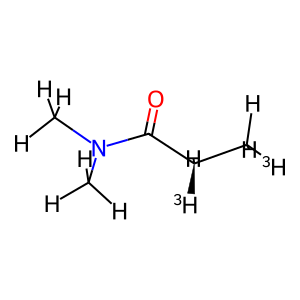

In [13]:
smiles_dma = '*CC(*)C(=O)N(C)C'
dma = utils.mol_from_smiles(smiles_dma)
AllChem.MMFFOptimizeMolecule(dma)
Chem.Draw.MolToImage(dma)

In [14]:
molblock = Chem.MolToMolBlock(dma)
#export_mol = openbabel.pybel.readstring('mol',molblock)
#export_mol.write(format='gjc', filename='./dma_unoptimized2.com')
#print(export_mol)

In [15]:
# save molecule
with Chem.SDWriter('dimethylacrylamide_with_props.sdf') as writer:
    writer.write(dma)

# Model chain charges

In [55]:
# load in model_dp7 chain charges
def read_charges(file_paths):
    master = []
    for file_path in file_paths:
        with open(file_path) as file:
            data = file.read().split(',')
            charges = []
            for charge in data:
                charges.append(float(charge))
        master.append(charges)
    return pd.DataFrame(master).T

chrgs = read_charges(['./input/chain0_resp_charges.csv', './input/chain1_resp_charges.csv', './input/chain2_resp_charges.csv'])
chrgs['mean'] = chrgs.mean(axis=1)
chrgs['std'] = chrgs.drop('mean', axis=1).std(axis=1)

model_dpn = 7
natoms_head = 20
natoms_body=16
natoms_tail = 20
natoms_tot = natoms_head + natoms_tail + (model_dpn-2)*natoms_body
body_idxs = [natoms_head, natoms_tot-natoms_tail]

#chrgs.sort_values('std', ascending=False).head(10)
head_charge = chrgs['mean'].iloc[0:(natoms_head)].to_numpy()
body_series = chrgs['mean'].iloc[body_idxs[0]:body_idxs[1]]
body_df = pd.DataFrame(body_series.values.reshape((model_dpn-2), natoms_body)).T
body_charge = body_df.mean(axis=1).to_numpy()
tail_charge = chrgs['mean'].iloc[(natoms_tot-natoms_tail):].to_numpy()

# make charge neutral
head_charge = list(head_charge - head_charge.sum()/len(head_charge))
body_charge = list(body_charge - body_charge.sum()/len(body_charge))
tail_charge = list(tail_charge - tail_charge.sum()/len(tail_charge))

print(len(head_charge), len(body_charge), len(tail_charge))

with open("input/head_charges.json", "w") as f: json.dump(head_charge, f)
with open("input/body_charges.json", "w") as f: json.dump(body_charge, f)
with open("input/tail_charges.json", "w") as f: json.dump(tail_charge, f)

20 16 20


# Single Chain Workflow

In [78]:
# Single chain example
# variables
dp_n = 7 # degree of polymerization for polymer
p_meso = 0.9 # probability of mesodiad formation
sdf_file = './dump/test.sdf' # sdf mol file output
data_file = './dump/test.data' # lammps data file output
template = './input/single_chain_template.lammps' # path to lammps input template
data_file_relative = './test.data' # path to data file relative to script
script_file = './dump/test.input.lammps' # lammps script file output
log_file = './test.log.lammps' # relative path of log file
spring_strength = 10.0

# load monomer
monomer = Chem.SDMolSupplier('./input/dma_opt.sdf', removeHs=False)[0]
ter = utils.mol_from_smiles('*C')

# make n=dp_n polymer with tacticity and terminate it
tac_arr = make_chain_end_tacticity_arr(dp_n, p_meso)
polymer = poly.polymerize_mols(monomer, n=dp_n, tacticity='manual', tac_array=tac_arr)
polymer = poly.terminate_mols(polymer, ter)

# enforce model chain charges
enforce_charges(polymer, head_charge, body_charge, tail_charge)

# assign charges
# qm.assign_charges(polymer, charge='gasteiger')

# assign force feild parameters
ff = GAFF2_mod()
result = ff.ff_assign(polymer)

# transform polymer coordinates to center and align chain on z-axis
transform_polymer_coords_to_zaxis(polymer)

# save RDkit object
write_mol(polymer, sdf_file)

# save lammps data file
lammps.MolToLAMMPSdata(polymer, data_file)

# create lammps input file
make_lammps_script_single_chain(polymer, template, script_file, data_file_relative, log_file=log_file, spring_strength=spring_strength)

In [ ]:
# making multiple single chains
def generate_single_chains(n_chains, dp_n, p_meso, work_dir, name='single_chain', spring_strength=50.0, log='full_process.log', quiet=True):
    # load monomer
    monomer = Chem.SDMolSupplier('./input/dma_opt.sdf', removeHs=False)[0]
    ter = utils.mol_from_smiles('*C')
    # load model chain charges
    with open("input/head_charges.json", "r") as f: head_charge = json.load(f)
    with open("input/body_charges.json", "r") as f: body_charge = json.load(f)
    with open("input/tail_charges.json", "r") as f: tail_charge = json.load(f)

    # make working directory and switch to it
    og_dir = os.getcwd()
    if not quiet: print("Current working directory:", og_dir)
    os.makedirs(work_dir, exist_ok=True)
    if not quiet: print('Changing working directory to:', work_dir)
    os.chdir(work_dir)

    # create a log file for the whole process
    process_log = open(log, 'w')

    try:
        for n in range(n_chains):
            # set up all file paths
            sdf_file = name + str(n) + '.sdf' # sdf mol file output
            data_file = name + str(n) + '.data' # lammps data file output
            template = '/home/ggolde/projects/polyheatline/dma_tacticity_clean/input/single_chain_template.lammps' # path to lammps input template
            data_file_relative = name + str(n) + '.data' # path to data file relative to script
            script_file = name + str(n) + '.input.lammps' # lammps script file output
            log_file = name + str(n) + '.log.lammps' # relative path of log file
            data_output_file = name + str(n) + '.output.data' # minimized output file

            # make n=dp_n polymer with tacticity and terminate it
            tac_arr = make_chain_end_tacticity_arr(dp_n, p_meso)
            polymer = poly.polymerize_mols(monomer, n=dp_n, tacticity='manual', tac_array=tac_arr)
            polymer = poly.terminate_mols(polymer, ter)
            
            # assign charges
            enforce_charges(polymer, head_charge, body_charge, tail_charge)

            # assign force feild parameters
            ff = GAFF2_mod()
            result = ff.ff_assign(polymer)

            # transform polymer coordinates to center and align chain on z-axis
            transform_polymer_coords_to_zaxis(polymer)

            # save RDkit object
            write_mol(polymer, sdf_file)

            # save lammps data file
            lammps.MolToLAMMPSdata(polymer, data_file)

            # create lammps input file
            make_lammps_script_single_chain(polymer, template, script_file, data_file_relative, data_output_file, log_file, spring_strength)

            # run the lammps script
            subprocess.run(['mpirun', '-np', '8', 'lmp', '-in', script_file], stdout=process_log)
        if not quiet: print(f'Successfuly generated {n_chains} of DPn {dp_n} with tacticity control {p_meso}!')
    
    finally:
        process_log.close()
        if not quiet: print('Changing working directory back to:', og_dir)
        os.chdir(og_dir)

    return 0

In [14]:
generate_single_chains(n_chains=9, dp_n=100, p_meso=0.9, work_dir='./single_chains/dp100_tact90')

Current working directory: /home/ggolde/projects/polyheatline/dma_tacticity_clean
Changing working directory to: ./single_chains/dp100_tact90
Successfuly generated 9 of DPn 100 with tacticity control 0.9!
Changing working directory back to: /home/ggolde/projects/polyheatline/dma_tacticity_clean


0

# Building aligned polymer simulation box

In [ ]:
# how to build box
# 1: poly.combine_mols? YES
# might want to align to z-axis again
# a: offset x, y function ?

In [ ]:
aligned_box_flag_dict = {
    'LOG':'md.log',
    'SPRING_STRENGTH':'10.0',
    'MAX_PRESS':'5000.0',
    'RESTART':'md.rst',
    'DUMP_MIN':'dump.min.lammpstrj',
    'DUMP_MD':'dump.md.lammpstrj',
    'DUMP_MD_UNWRAPPED':'dump.md_unwrapped.lammpstrj',
    'DUMP_LAST':'dump.final_state.lammpstrj',
    'DATA_OUTPUT':'final.data'
}

In [ ]:
def make_lammps_script_aligned_box(template_file, output_file, flag_dict):
    # read in template
    with open(template_file, 'r') as fin:
        modified_script = fin.read()
    # replace all flags with args
    for key, value in flag_dict.items():
        flag = '!FLAG<' + key + '>'
        modified_script = modified_script.replace(flag, value)
    # check for remaining flags
    if "!FLAG" in modified_script:
        raise RuntimeError('Not all flags were replaced in the output script.')
    # write out lammps script
    with open(output_file, 'w') as fout:
        fout.write(modified_script)

In [ ]:
def make_aligned_box_and_script(monomer_file, path_to_single_chains, n_chains, n_by_n, output_data_name, tempalte_file, script_flag_dict, work_dir, output_script_name='input.lammps', chain_names='single_chains', ter_smiles='*C', quiet=True):
    # load monomer and terminater mols
    monomer = Chem.SDMolSupplier(monomer_file, removeHs=False)[0]
    ter = utils.mol_from_smiles(ter_smiles)
    # load single chains
    listofpolys = [lammps.MolFromLAMMPSdata((path_to_single_chains + chain_names + str(i) + '.output.data')) for i in range(n_chains)]
    
    for mol in listofpolys:
        term_idxs = infer_term_idxs(monomer, mol, ter)
        transform_polymer_coords_to_zaxis(mol, term_idxs)

    cell = build_aligned_box(listofpolys, n_by_n[0], n_by_n[1], xy_offset=[14, 14], xyz_margins=[2,2,1])
    lammps.MolToLAMMPSdata(cell, work_dir + output_data_name + '.data')
    write_mol(cell, work_dir + output_data_name + '.xyz', ext='xyz')

    if not quiet: print('Terminal atom indicies:', infer_term_idxs(monomer, listofpolys[0], ter, n=n_chains))
    if not quiet: print('Cell dimensions:\n', '\tx', cell.cell.xhi, cell.cell.xlo, '\n', '\ty', cell.cell.yhi, cell.cell.ylo, '\n', '\tz', cell.cell.zhi, cell.cell.zlo)

    script_flag_dict['HEAD_TAIL_IDXS'] = infer_term_idxs(monomer, listofpolys[0], ter, n=n_chains)
    script_flag_dict['DATA_INPUT'] = output_data_name + '.data'
    
    make_lammps_script_aligned_box(tempalte_file, work_dir + output_script_name, script_flag_dict)


In [16]:
# load monomer for reference
monomer = Chem.SDMolSupplier('./input/dma_opt.sdf', removeHs=False)[0]
ter = utils.mol_from_smiles('*C')

In [ ]:
listopoly = [lammps.MolFromLAMMPSdata(('./single_chains/dp100_tact90/single_chain' + str(i) + '.output.data')) for i in range(9)]
for mol in listopoly:
    term_idxs = infer_term_idxs(monomer, mol, ter)
    transform_polymer_coords_to_zaxis(mol, term_idxs)

cell = build_aligned_box(listopoly, 3, 3, xy_offset=[14, 14], xyz_margins=[2,2,1])
lammps.MolToLAMMPSdata(cell, './aligned_cells/n9_dp100_tact90ce.data')
write_mol(cell, './aligned_cells/n9_dp100_tact90ce.xyz', ext='xyz')

print('Terminal atom indicies:', infer_term_idxs(monomer, listopoly[0], ter, n=4))
print('Cell dimensions:\n',
      '\tx', cell.cell.xhi, cell.cell.xlo, '\n',
      '\ty', cell.cell.yhi, cell.cell.ylo, '\n',
      '\tz', cell.cell.zhi, cell.cell.zlo)
      

Terminal atom indicies: 1 1605 1609 3213 3217 4821 4825 6429
Cell dimensions:
 	x 37.53603198347787 -7.239905317127021 
 	y 35.91491718855943 -8.581536247012705 
 	z 220.53852066167465 -1.935942278566301


In [ ]:
aligned_box_flag_dict = {
    'LOG':'n9_dp100_short_protocol.log',
    'DATA_INPUT':'n9_dp100_tact90ce.data',
    'HEAD_TAIL_IDXS':infer_term_idxs(monomer, listopoly[0], ter, n=4),
    'SPRING_STRENGTH':'10.0',
    'MAX_PRESS':'5000.0',
    'RESTART':'md.rst',
    'DUMP_MIN':'dump.min.lammpstrj',
    'DUMP_MD':'dump.md.lammpstrj',
    'DUMP_MD_UNWRAPPED':'dump.md_unwrapped.lammpstrj',
    'DUMP_LAST':'dump.final_state.lammpstrj',
    'DATA_OUTPUT':'final.data'
}

In [81]:
make_lammps_script_aligned_box('./input/aligned_box_template_21step.lammps', './md/export/input.n9_dp100_tact90ce.lammps', aligned_box_flag_dict)

['Density', 'E_angle', 'E_bond', 'E_coul', 'E_dihed', 'E_impro', 'E_long', 'E_tail', 'E_vdwl', 'Enthalpy', 'KinEng', 'Lx', 'Ly', 'Lz', 'PotEng', 'Press', 'Pxx', 'Pxy', 'Pxz', 'Pyy', 'Pyz', 'Pzz', 'Step', 'Temp', 'Time', 'TotEng', 'Volume']


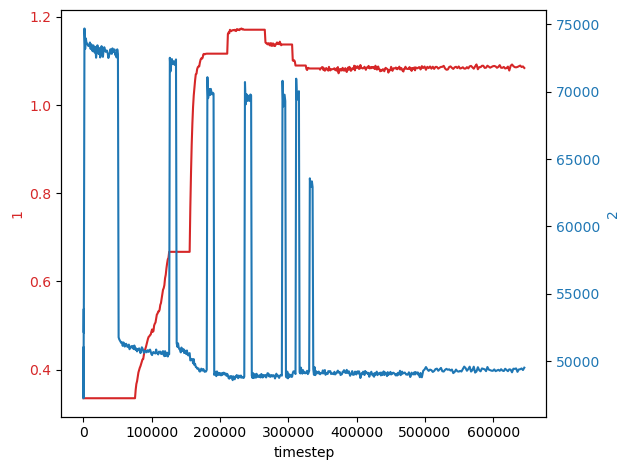

In [15]:
try5 = read_lammps_log('./md/hpg_logs/tester_n4_dp10.log')
print(try5.get_keywords())
t = try5.get('Time')
data1 = try5.get('Density')
data2 = try5.get('TotEng')

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('timestep')
ax1.set_ylabel('1', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('2', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

#plt.xlim((0.675e6,1e6))

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [75]:
100+25+50+90+30+30+150

475